In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/6th sem project"


'model (1).h5'					        test_essays.csv
 model_draft2.h5				        train_essays.csv
'new_approach_using_bert_and_vectorization (1).ipynb'   train_prompts.csv
 subtaskA_train_monolingual.jsonl		        train_v2_drcat_02.csv


In [ ]:
!cp "/content/drive/My Drive/6th sem project/train_essays.csv" "train_essays.csv"
!cp "/content/drive/My Drive/6th sem project/test_essays.csv" "test_essays.csv"
!cp "/content/drive/My Drive/6th sem project/train_prompts.csv" "train_prompts.csv"
!cp "/content/drive/My Drive/6th sem project/train_v2_drcat_02.csv" "train_v2_drcat_02.csv"

In [ ]:
pip install tensorflow-text


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      S

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import tensorflow_text as tf_text
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras import Model, Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [ ]:
train=pd.read_csv("train_essays.csv")
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [ ]:
test=pd.read_csv("test_essays.csv")
test.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [ ]:
train_prompts=pd.read_csv("train_prompts.csv")
train_prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [ ]:
train['prompt_id'].value_counts()

prompt_id
0    708
1    670
Name: count, dtype: int64

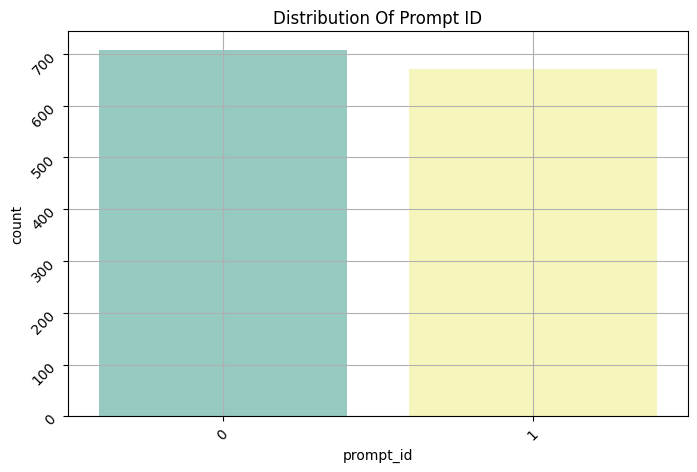

In [ ]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train,x="prompt_id",palette='Set3')
abs_values = train['prompt_id'].value_counts().values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Prompt ID")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [ ]:
train['generated'].value_counts()#0: human, 1: ai


generated
0    1375
1       3
Name: count, dtype: int64

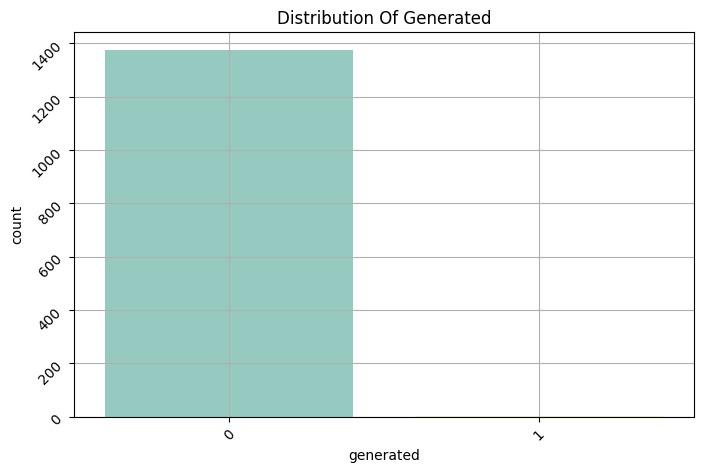

In [ ]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train,x="generated",palette='Set3')
abs_values = train['generated'].value_counts().values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Generated")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
new_data=pd.read_csv("train_v2_drcat_02.csv")
new_data.head()

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


In [ ]:
new_data.label.value_counts()

label
0    27371
1    17497
Name: count, dtype: int64

In [ ]:
train_prompts.prompt_name.value_counts()

prompt_name
Car-free cities                     1
Does the electoral college work?    1
Name: count, dtype: int64

In [ ]:
new_data.prompt_name.value_counts()

prompt_name
Distance learning                        5554
Seeking multiple opinions                5176
Car-free cities                          4717
Does the electoral college work?         4434
Facial action coding system              3084
Mandatory extracurricular activities     3077
Summer projects                          2701
Driverless cars                          2250
Exploring Venus                          2176
Cell phones at school                    2119
Grades for extracurricular activities    2116
Community service                        2092
"A Cowboy Who Rode the Waves"            1896
The Face on Mars                         1893
Phones and driving                       1583
Name: count, dtype: int64

In [ ]:
new_=new_data.iloc[:, 0:2][new_data['prompt_name'].isin(train_prompts['prompt_name'].values)]
new_

,text,label
1168,Cars have been around for awhile and they have...,0
1169,Have you ever thought what it would be like no...,0
1170,What you are about to read is going to give yo...,0
1171,cars have many flaws nd and in this day and ag...,0
1172,There are many advantages of limiting car usag...,0
...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1
44864,"Dear Senator,\n\nI am writing to you today to ...",1
44865,"Dear Senator,\n\nI am writing to you today to ...",1
44866,"Dear Senator,\n\nI am writing to you today to ...",1


In [ ]:
t=train.iloc[:,2:]
t.columns=['text','label']
train_data=pd.concat([new_,t])
train_data=train_data.reset_index().iloc[:,1:]
train_data.head()

,text,label
0,Cars have been around for awhile and they have...,0
1,Have you ever thought what it would be like no...,0
2,What you are about to read is going to give yo...,0
3,cars have many flaws nd and in this day and ag...,0
4,There are many advantages of limiting car usag...,0


In [ ]:
train_data.label.value_counts()

label
0    6755
1    3774
Name: count, dtype: int64

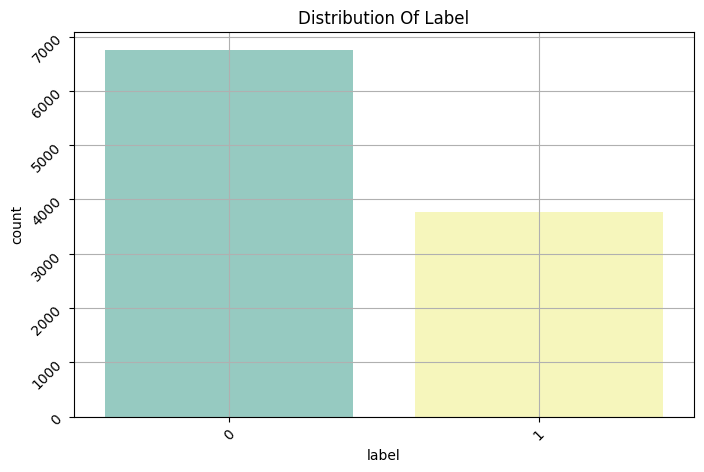

In [ ]:
plt.figure(figsize=(8,5))
ax=sns.countplot(data=train_data,x="label",palette='Set3')
abs_values = train_data['label'].value_counts().values
# ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title("Distribution Of Label")
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
import nltk

# Filter essays by label 0 and calculate average sentence length
avg_length_label_0 = train_data[train_data['label'] == 0]['text'].apply(lambda x: len(nltk.word_tokenize(x))).mean()
print("Average length of sentences for label 0:", avg_length_label_0)

# Filter essays by label 1 and calculate average sentence length
avg_length_label_1 = train_data[train_data['label'] == 1]['text'].apply(lambda x: len(nltk.word_tokenize(x))).mean()
print("Average length of sentences for label 1:", avg_length_label_1)


Average length of sentences for label 0: 534.980014803849
Average length of sentences for label 1: 448.24191838897724


In [ ]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

# Load the spaCy model with GloVe embeddings
nlp = spacy.load("en_core_web_md")

# Function to get the mean GloVe embedding for a sentence
def get_mean_embedding(sentence):
    # Process the sentence with spaCy
    doc = nlp(sentence)
    # Calculate the mean embedding for the sentence
    mean_embedding = np.mean([token.vector for token in doc], axis=0)
    return mean_embedding


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to compute semantic similarity between two sentences
def compute_semantic_similarity(sentence1, sentence2):
    # Get GloVe embeddings for each sentence
    embedding1 = get_mean_embedding(sentence1)
    embedding2 = get_mean_embedding(sentence2)

    # Compute cosine similarity between embeddings
    similarity_score = cosine_similarity([embedding1], [embedding2])[0][0]

    return similarity_score

# Select 10 essays labeled as 0 and 10 essays labeled as 1
essays_0 = train_data[train_data['label'] == 0]['text'].sample(n=10, random_state=42)
essays_1 = train_data[train_data['label'] == 1]['text'].sample(n=10, random_state=42)

# Initialize lists to store pairs of sentences and their semantic similarity scores
similarity_scores = []

# Iterate over each pair of essays, one from each label group
for essay_0, essay_1 in zip(essays_0, essays_1):
    # Compute semantic similarity between the pair of essays
    similarity_score = compute_semantic_similarity(essay_0, essay_1)

    # Append the similarity score to the list
    similarity_scores.append(similarity_score)

# Convert list to numpy array for further processing
similarity_scores = np.array(similarity_scores)

# Print the similarity scores
print("Semantic similarity scores for each pair:")
print(similarity_scores)


Semantic similarity scores for each pair:
[0.97548896 0.9524798  0.949089   0.9407563  0.9153832  0.96805066
 0.9163233  0.9463548  0.82741654 0.8988874 ]


text cleaning


In [ ]:
import pandas as pd
import re
import nltk
from collections import Counter
import tensorflow_text as tf_text
import textstat

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Function to calculate POS tag ratios
def calculate_pos_tag_ratios(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Perform POS tagging
    pos_tags = nltk.pos_tag(tokens)

    # Count occurrences of each POS tag
    pos_tag_counts = Counter(tag for word, tag in pos_tags)

    # Calculate ratios relative to the total number of words
    total_words = len(tokens)
    pos_tag_ratios = {tag: count / total_words for tag, count in pos_tag_counts.items()}

    return pos_tag_ratios

def preprocess_text(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.regex_replace(text, '\.\.\.', ' ')

    # Calculate readability scores
    fkgl, gfi = textstat.flesch_kincaid_grade(text.numpy().decode('utf-8')), textstat.gunning_fog(text.numpy().decode('utf-8'))

    # Calculate POS tag ratios
    pos_tag_ratios = calculate_pos_tag_ratios(text.numpy().decode('utf-8'))

    return text.numpy().decode('utf-8'), fkgl, gfi, pos_tag_ratios

# Apply preprocessing to the text column
train_data[['cleaned_text', 'fkgl_score', 'gfi_score', 'pos_tag_ratios']] = train_data['text'].apply(lambda x: pd.Series(preprocess_text(x)))

print(train_data[['cleaned_text', 'fkgl_score', 'gfi_score', 'pos_tag_ratios']])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


                                            cleaned_text  fkgl_score  \
0      cars have been around for awhile and they have...         8.1   
1      have you ever thought what it would be like no...         7.9   
2      what you are about to read is going to give yo...         9.3   
3      cars have many flaws nd and in this day and ag...         6.1   
4      there are many advantages of limiting car usag...         9.3   
...                                                  ...         ...   
10524  there has been a fuss about the elector colleg...         6.2   
10525  limiting car usage has many advantages .  such...         8.9   
10526  theres a new trend that has been developing fo...        10.1   
10527  as we all know cars are a big part of our soci...         6.1   
10528  cars have been around since the s and have bee...         8.5   

       gfi_score                                     pos_tag_ratios  
0          10.20  {'NNS': 0.09915966386554621, 'VBP': 0.04873949.

In [ ]:
# Calculate average POS tag ratios differentiated by label
average_pos_tag_ratios_by_label = train_data.groupby('label')['pos_tag_ratios'].apply(lambda x: pd.DataFrame(x.tolist()).mean()).reset_index()

# Grouping all '0' labels together and all '1' labels together, and calculating their average
average_pos_tag_ratios_combined = average_pos_tag_ratios_by_label.groupby('label')['pos_tag_ratios'].apply(lambda x: pd.DataFrame(x.tolist()).mean()).reset_index()

print("Average POS tag ratios clubbed by '0' and '1':")
print(average_pos_tag_ratios_combined)


Average POS tag ratios clubbed by '0' and '1':
   label  level_1  pos_tag_ratios
0      0        0        0.027189
1      1        0        0.029696


In [ ]:
pip install textstat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import textstat
import tensorflow_text as tf_text

def calculate_readability_scores(text):
    fkgl = textstat.flesch_kincaid_grade(text)
    gfi = textstat.gunning_fog(text)
    return fkgl, gfi
def preprocess_text(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.regex_replace(text, '\.\.\.', ' ')


    fkgl, gfi = calculate_readability_scores(text.numpy().decode('utf-8'))

    return text.numpy().decode('utf-8'), fkgl, gfi
train_data[['cleaned_text', 'fkgl_score', 'gfi_score']] = train_data['text'].apply(lambda x: pd.Series(preprocess_text(x)))
print(train_data[['cleaned_text', 'fkgl_score', 'gfi_score']])


                                            cleaned_text  fkgl_score  \
0      cars have been around for awhile and they have...         8.1   
1      have you ever thought what it would be like no...         7.9   
2      what you are about to read is going to give yo...         9.3   
3      cars have many flaws nd and in this day and ag...         6.1   
4      there are many advantages of limiting car usag...         9.3   
...                                                  ...         ...   
10524  there has been a fuss about the elector colleg...         6.2   
10525  limiting car usage has many advantages .  such...         8.9   
10526  theres a new trend that has been developing fo...        10.1   
10527  as we all know cars are a big part of our soci...         6.1   
10528  cars have been around since the s and have bee...         8.5   

       gfi_score  
0          10.20  
1           9.89  
2          11.92  
3           7.72  
4          10.31  
...          ...  
10

In [ ]:
average_scores_by_label = train_data.groupby('label').agg({'fkgl_score': 'mean', 'gfi_score': 'mean'})


print("Average readability scores differentiated by label:")
print(average_scores_by_label)


Average readability scores differentiated by label:
       fkgl_score  gfi_score
label                       
0        9.010570  10.509001
1       10.403922  11.207313


Text Vectorization


In [ ]:
max_features = 75000#max number of words that will be used in predictions-unique
embedding_dim = 64
sequence_length = 512*2#The maximum length of the sequences. It's set to 512*2, which implies sequences of up to 1024 tokens.
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=Clean ,#jo apan ne nfkd se clean function define kiye the for stopwords punctuation marks removal wo clean hai
    max_tokens=max_features,#75000 words hee only for consideration
    ngrams = (3,5),#subsets of 3 to 5 words for better semantic understanding of the sentence
    output_mode="int",#conversion of text into int format
    output_sequence_length=sequence_length,#1024 length honi chahiye
    pad_to_max_tokens=True#kam rha to padding add kardo
)
vectorize_layer.adapt(train_data['text'])
Text = vectorize_layer(train_data['text']).numpy()
Text

array([[ 1138, 19101,  5729, ...,     1,     1,     1],
       [ 3796, 10859,     1, ...,     0,     0,     0],
       [28184,     1, 53697, ...,     1,     1,     1],
       ...,
       [    1, 31053,     1, ...,     1,     1,     1],
       [24714,  8587,     1, ...,     1,     1,     1],
       [ 1138, 19101, 21592, ...,     0,     0,     0]])

In [ ]:
sm = SMOTE(random_state=44)#imbalance in data for balancing
Text,labels= sm.fit_resample(Text,train_data['label'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Text,labels, test_size=0.2, random_state=44, shuffle =True,stratify=labels)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (10808, 1024)
X_test shape is  (2702, 1024)
y_train shape is  (10808,)
y_test shape is  (2702,)


transformers block


In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

# Define your TransformerBlock class

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=True):  # Include 'training' argument with default value
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Assuming the rest of your code remains the same...

# Define your model architecture

inputs = Input(shape=(sequence_length,), dtype="int64")#expected input format ya dimension mai convert akrdega
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)#two layers start from left and right both-previous and next words in memory for better understanding of coontext and relationship between words

# Add TransformerBlock

transformer_block = TransformerBlock(embedding_dim, 2, 32)#j apan ne layer bnaye upar of self attention and ffn wo apply kardo yaha pe
x = transformer_block(x, training=True)  # Pass 'training' argument

# Continue with the rest of your model architecture

x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)#9x9 matrix pe 3x3 matrix frame fko slide karta linearly and best features extract karne ka try akrta hai
x = GlobalMaxPooling1D()(x)#dimensiona reduce
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

# Define the model

model = Model(inputs=inputs, outputs=predictions)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 1024, 64)            │       4,800,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1024, 64)            │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 1024, 64)            │          37,664 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 340, 128)            │          57,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predictions (Dense)                  │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,936,609 (18.83 MB)

 Trainable params: 4,936,609 (18.83 MB)

 Non-trainable params: 0 (0.00 B)

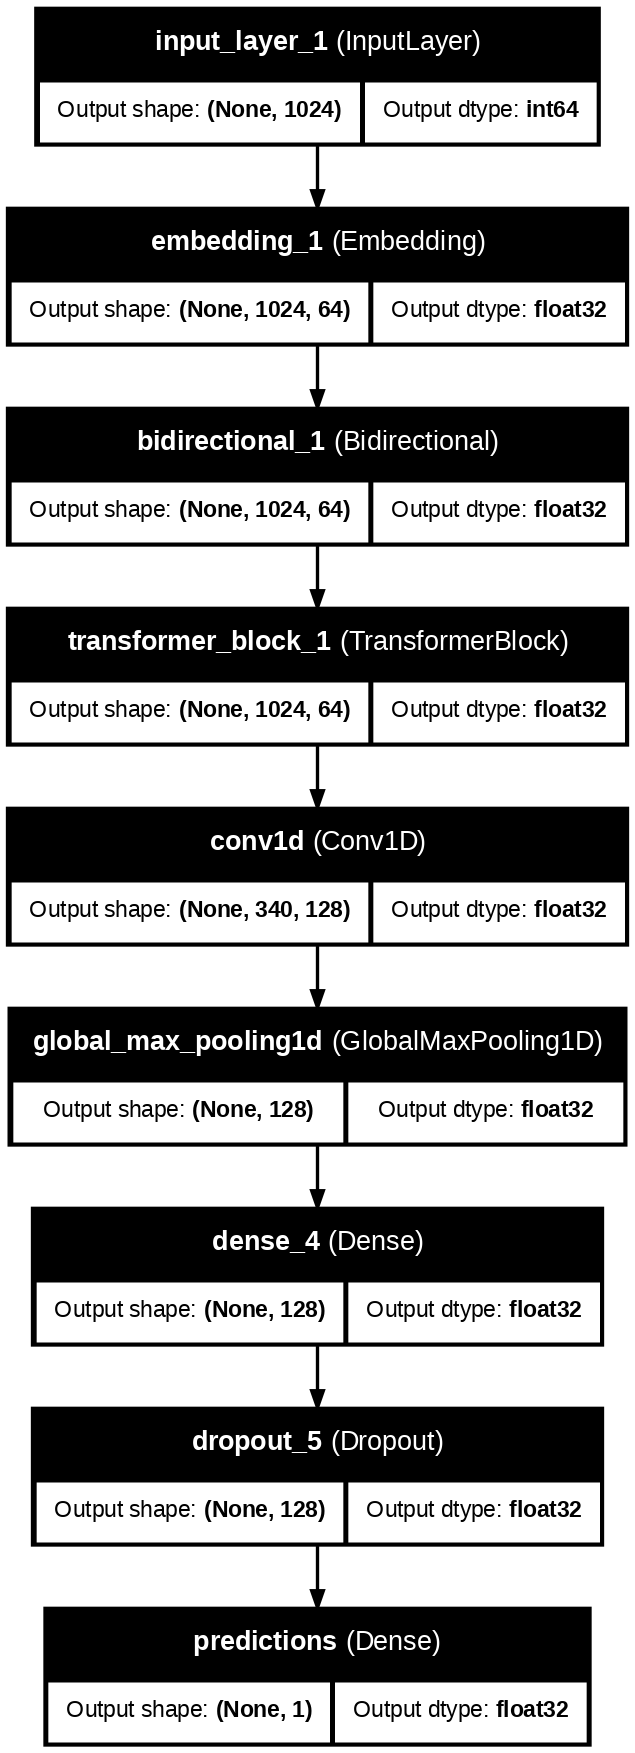

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:

early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=5, validation_split=0.1, callbacks=[checkpoint_cb, early_stopping_cb])


NameError: name 'checkpoint_cb' is not defined

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.119656,0.954457,0.013558,0.995375
1,0.011726,0.996710,0.016245,0.995375
2,0.003490,0.998972,0.022946,0.994450
3,0.000096,1.000000,0.025434,0.992599


In [ ]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

85/85 [==============================] - 138s 2s/step - loss: 0.0140 - accuracy: 0.9944
Test Loss = 0.01399681344628334
Test Accuracy = 0.9944485425949097


In [ ]:
predictions = model.predict(X_test)
y_pred = np.where(predictions>=.5,1,0)
y_test_1d = np.ravel(y_test)
y_pred_1d = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test_1d, 'Prediction': y_pred_1d})
df

85/85 [==============================] - 142s 2s/step


,Actual,Prediction
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
2697,0,0
2698,1,1
2699,0,0
2700,1,1


array([[1342,    9],
       [   6, 1345]])

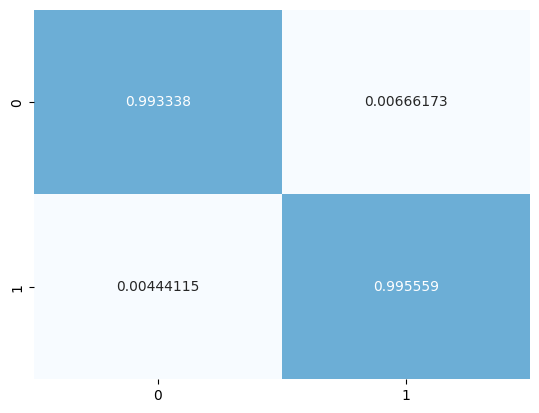

In [ ]:
CM = confusion_matrix(y_test_1d,y_pred_1d)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test_1d,y_pred_1d)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       1.00      0.99      0.99      1351
           1       0.99      1.00      0.99      1351

    accuracy                           0.99      2702
   macro avg       0.99      0.99      0.99      2702
weighted avg       0.99      0.99      0.99      2702



In [ ]:
print(X_test)

[[13963  7984  4061 ...     0     0     0]
 [31530 10384     1 ...     1     1     1]
 [  112    79    77 ...     0     0     0]
 ...
 [  638   784   247 ...     0     0     0]
 [  112    79  4022 ...     1 14882 16140]
 [    1 27606     1 ...     0     0     0]]


In [ ]:
!cp "/content/drive/My Drive/6th sem project/subtaskA_train_monolingual.jsonl" "subtaskA_train_monolingual.jsonl"

In [ ]:
print("hey")

hey


In [ ]:
human1="car free cities is a topic being talked about a lot but very hard to implement in real life.Its a concept being introduceed way too early than it can be implemented.More than 80 percent of working individuals depend on cars for travelling to and from their workplace .Not even talking about how many important services like ambulance ,police are all based on motor vehicles which cant be relaced any soon .it does offer a hell lot of advantages like less pollution,healthy lifestyle as more and more people will indulge in walking to nearby places where they didnt used to as there was an availability of their own car or pretty famous these days -cab services.we cant ignore the disadvantages in this concept-it will lead to big manufacturing companies in turn shutting down which will lead to unemployment issues and our country is not in a state where it can afford more of unemployment as the IT crisis exists beforehand."

In [ ]:
cleaned_paragraph=clean_text(human1)
# print(cleaned_paragraph)
cleaned_paragraph=Clean(human1)
print(cleaned_paragraph)

tf.Tensor(b' car free cities is a topic being talked about a lot but very hard to implement in real life . its a concept being introduceed way too early than it can be implemented . more than  percent of working individuals depend on cars for travelling to and from their workplace  . not even talking about how many important services like ambulance  , police are all based on motor vehicles which cant be relaced any soon  . it does offer a hell lot of advantages like less pollution , healthy lifestyle as more and more people will indulge in walking to nearby places where they didnt used to as there was an availability of their own car or pretty famous these days cab services . we cant ignore the disadvantages in this conceptit will lead to big manufacturing companies in turn shutting down which will lead to unemployment issues and our country is not in a state where it can afford more of unemployment as the it crisis exists beforehand . ', shape=(), dtype=string)


In [ ]:
vectorized_paragraph = vectorize_layer([cleaned_paragraph])

In [ ]:
prediction = model.predict(vectorized_paragraph)
rounded_prediction = np.round(prediction).astype(int)

1/1 [==============================] - 0s 200ms/step


In [ ]:
print("Rounded Prediction:", rounded_prediction)

Rounded Prediction: [[0]]


In [ ]:
human2="have you ever imagined what would have happened if cars- that are now  such an important part of our day to day lives would have not exsisted. probably the cities we live in would be just as we want them to be , less pollution, no long traffic queue  and no loud horn noises.  cars are one of the main cause for air pollution and so there would be less emission which eventually make the air quality index rise. not only pollution but the death cause due to car accidents are also something that we hear about every now and then, which would be saved . other mass transportation services would be preferred  and hence would have helped in achieving sustainability"

In [ ]:
cleaned_paragraph=clean_text(human2)
# print(cleaned_paragraph)
cleaned_paragraph=Clean(human2)
print(cleaned_paragraph)

tf.Tensor(b' have you ever imagined what would have happened if cars that are now  such an important part of our day to day lives would have not exsisted .  probably the cities we live in would be just as we want them to be  ,  less pollution ,  no long traffic queue  and no loud horn noises .   cars are one of the main cause for air pollution and so there would be less emission which eventually make the air quality index rise .  not only pollution but the death cause due to car accidents are also something that we hear about every now and then ,  which would be saved  .  other mass transportation services would be preferred  and hence would have helped in achieving sustainability ', shape=(), dtype=string)


In [ ]:
vectorized_paragraph = vectorize_layer([cleaned_paragraph])

In [ ]:
prediction = model.predict(vectorized_paragraph)
rounded_prediction = np.round(prediction).astype(int)

1/1 [==============================] - 0s 111ms/step


In [ ]:
print("Rounded Prediction:", rounded_prediction)

Rounded Prediction: [[1]]


In [ ]:
import pandas as pd

# Read the JSON Lines file into a DataFrame
df = pd.read_json('subtaskA_train_monolingual.jsonl', lines=True)

# Now 'df' contains the JSON data in a DataFrame format
print(df)


                                                     text  label    model  \
0       Forza Motorsport is a popular racing game that...      1  chatGPT   
1       Buying Virtual Console games for your Nintendo...      1  chatGPT   
2       Windows NT 4.0 was a popular operating system ...      1  chatGPT   
3       How to Make Perfume\n\nPerfume is a great way ...      1  chatGPT   
4       How to Convert Song Lyrics to a Song'\n\nConve...      1  chatGPT   
...                                                   ...    ...      ...   
119752  The paper is an interesting contribution, prim...      0    human   
119753  \nWe thank the reviewers for all their comment...      0    human   
119754  The authors introduce a semi-supervised method...      0    human   
119755  This paper proposes the Neural Graph Machine t...      0    human   
119756  The paper proposes a model that aims at learni...      0    human   

          source      id  
0        wikihow       0  
1        wikihow     

In [ ]:
df['text'] = df['text'].apply(Clean)

In [ ]:
# Assuming you have read the JSON Lines file into a DataFrame and cleaned the text data
texts = df['text'].tolist()  # Convert the text data to a list of strings
vectorized_text = vectorize_layer(texts)  # Apply the TextVectorization layer


In [ ]:
vectorized_text_subset = vectorized_text[:50000]

In [ ]:
predictions_subset = model.predict(vectorized_text_subset)

1563/1563 [==============================] - 2796s 2s/step


In [ ]:
binary_predictions_subset = (predictions_subset > 0.1).astype('int32')

In [ ]:
from sklearn.metrics import accuracy_score

y_true_subset = df['label'].tolist()[:50000]  # Extract ground truth labels for the subset
accuracy_subset = accuracy_score(y_true_subset, binary_predictions_subset)
print("Accuracy for the subset:", accuracy_subset)

Accuracy for the subset: 0.95056


In [ ]:
# Add a column of predictions to the DataFrame for the subset
df_subset = df.head(50000)  # Extract the first 10,000 rows of the DataFrame
df_subset['predicted_label'] = binary_predictions_subset

In [ ]:
# Display the DataFrame with predictions and ground truth labels for the subset
print(df_subset[['text', 'label', 'predicted_label']])

                                                    text  label  \
0      tf.Tensor(b' forza motorsport is a popular rac...      1   
1      tf.Tensor(b' buying virtual console games for ...      1   
2      tf.Tensor(b' windows nt  .  was a popular oper...      1   
3      tf.Tensor(b' how to make perfumeperfume is a g...      1   
4      tf.Tensor(b' how to convert song lyrics to a s...      1   
...                                                  ...    ...   
49995  tf.Tensor(b' this paper attempts to solve a ve...      1   
49996  tf.Tensor(b' the paper prides itself on being ...      1   
49997  tf.Tensor(b' this paper is a good start for de...      1   
49998  tf.Tensor(b' the paper is technically sound . ...      1   
49999  tf.Tensor(b' the authors describe a method of ...      1   

       predicted_label  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
49995               